In [391]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.style.use('Solarize_Light2')

from sklearn.ensemble import IsolationForest
from sklearn.impute import SimpleImputer

def add_bar_labels(ax):
    #ax = plt.gca()
    for i in ax.patches:
        ax.text(i.get_x() + i.get_width() / 2., i.get_height(), 
                '%d' % int(i.get_height()), fontsize=10,
                ha="center", va='bottom')

In [226]:
df = pd.read_csv("cleaned_dataset_final.csv")

In [227]:
df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,class
0,IndiGo,2019-03-24,Banglore,New Delhi,22:20:00,01:10:00,170,0.0,No Info,3897,Economy
1,Air India,2019-05-01,Kolkata,Banglore,05:50:00,13:15:00,445,2.0,No Info,7662,Economy
2,Jet Airways,2019-06-09,Delhi,Cochin,09:25:00,04:25:00,1140,2.0,No Info,13882,Economy
3,IndiGo,2019-05-12,Kolkata,Banglore,18:05:00,23:30:00,325,1.0,No Info,6218,Economy
4,IndiGo,2019-03-01,Banglore,New Delhi,16:50:00,21:35:00,285,1.0,No Info,13302,Economy
...,...,...,...,...,...,...,...,...,...,...,...
10457,Air Asia,2019-04-09,Kolkata,Banglore,19:55:00,22:25:00,150,0.0,No Info,4107,Economy
10458,Air India,2019-04-27,Kolkata,Banglore,20:45:00,23:20:00,155,0.0,No Info,4145,Economy
10459,Jet Airways,2019-04-27,Banglore,Delhi,08:20:00,11:20:00,180,0.0,No Info,7229,Economy
10460,Vistara,2019-03-01,Banglore,New Delhi,11:30:00,14:10:00,160,0.0,No Info,12648,Economy


In [228]:
df.dtypes

airline             object
date_of_journey     object
source              object
destination         object
dep_time            object
arrival_time        object
duration             int64
total_stops        float64
additional_info     object
price                int64
class               object
dtype: object

In [229]:
for i in ['date_of_journey', 'dep_time', 'arrival_time']:
    df[i] = pd.to_datetime(df[i], dayfirst=True)

In [230]:
df.dtypes

airline                    object
date_of_journey    datetime64[ns]
source                     object
destination                object
dep_time           datetime64[ns]
arrival_time       datetime64[ns]
duration                    int64
total_stops               float64
additional_info            object
price                       int64
class                      object
dtype: object

In [231]:
df.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,class
0,IndiGo,2019-03-24,Banglore,New Delhi,2024-09-04 22:20:00,2024-09-04 01:10:00,170,0.0,No Info,3897,Economy
1,Air India,2019-05-01,Kolkata,Banglore,2024-09-04 05:50:00,2024-09-04 13:15:00,445,2.0,No Info,7662,Economy
2,Jet Airways,2019-06-09,Delhi,Cochin,2024-09-04 09:25:00,2024-09-04 04:25:00,1140,2.0,No Info,13882,Economy
3,IndiGo,2019-05-12,Kolkata,Banglore,2024-09-04 18:05:00,2024-09-04 23:30:00,325,1.0,No Info,6218,Economy
4,IndiGo,2019-03-01,Banglore,New Delhi,2024-09-04 16:50:00,2024-09-04 21:35:00,285,1.0,No Info,13302,Economy


In [232]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10462 entries, 0 to 10461
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          10462 non-null  object        
 1   date_of_journey  10462 non-null  datetime64[ns]
 2   source           10462 non-null  object        
 3   destination      10462 non-null  object        
 4   dep_time         10462 non-null  datetime64[ns]
 5   arrival_time     10462 non-null  datetime64[ns]
 6   duration         10462 non-null  int64         
 7   total_stops      10461 non-null  float64       
 8   additional_info  10462 non-null  object        
 9   price            10462 non-null  int64         
 10  class            10462 non-null  object        
dtypes: datetime64[ns](3), float64(1), int64(2), object(5)
memory usage: 899.2+ KB


In [233]:
df.drop(['total_stops'], axis = 1).describe(include = 'number')

,duration,price
count,10462.000000,10462.000000
mean,629.916842,9025.849073
std,500.721373,4624.162125
min,75.000000,1759.000000
25%,170.000000,5224.000000
50%,505.000000,8266.000000
75%,910.000000,12337.500000
max,2860.000000,79512.000000


In [234]:
(
    df
    .assign(total_stops=df["total_stops"].astype(object))
    .describe(include="O")
)

,airline,source,destination,total_stops,additional_info,class
count,10462,10462,10462,10461.0,10462,10462
unique,9,5,6,5.0,9,3
top,Jet Airways,Delhi,Cochin,1.0,No Info,Economy
freq,3706,4346,4346,5625.0,8185,10440


## HIGH LEVEL ANALYSIS OF MISSING VALUES

In [235]:
def missing_values(df):
    missing_col = [col for col in df.columns if df[col].isnull().any()]
    for i in missing_col:
        return f"{missing_col[0]}:-[{df[missing_col].isnull().sum()}]"


In [236]:
missing_values(df)

'total_stops:-[total_stops    1\ndtype: int64]'

In [237]:
df[pd.isna(df['total_stops'])]

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,class
8892,Air India,2019-05-06,Delhi,Cochin,2024-09-04 09:45:00,2024-09-04 09:25:00,1420,NaN,No Info,7480,Economy


In [238]:
# To fill the null value, we have tried to visualize or draw a data set, but from there we also have not gotten any insights,
# so we need to fill the null value using simple imputer.

In [239]:
imputer = SimpleImputer(strategy = 'most_frequent')
df_imputed = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)

for i in ['price', 'duration', 'total_stops']:
    df_imputed[i] = df_imputed[i].astype('int64') 

In [240]:
print(missing_values(df_imputed))

None


In [241]:
df = df_imputed

In [242]:
df.isnull().sum()

airline            0
date_of_journey    0
source             0
destination        0
dep_time           0
arrival_time       0
duration           0
total_stops        0
additional_info    0
price              0
class              0
dtype: int64

In [243]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10462 entries, 0 to 10461
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          10462 non-null  object        
 1   date_of_journey  10462 non-null  datetime64[ns]
 2   source           10462 non-null  object        
 3   destination      10462 non-null  object        
 4   dep_time         10462 non-null  datetime64[ns]
 5   arrival_time     10462 non-null  datetime64[ns]
 6   duration         10462 non-null  int64         
 7   total_stops      10462 non-null  int64         
 8   additional_info  10462 non-null  object        
 9   price            10462 non-null  int64         
 10  class            10462 non-null  object        
dtypes: datetime64[ns](3), int64(3), object(5)
memory usage: 899.2+ KB


## HIGH LEVEL ANALYSIS OF OUTLIER

In [244]:
forest = IsolationForest(n_estimators=10, random_state=42)

In [245]:
(
    df
    .assign(outlier = forest.fit_predict(df
                                        .drop(columns='price')
                                        .select_dtypes(include='number')))
    .query("outlier==-1")
)

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,class,outlier
1,Air India,2019-05-01,Kolkata,Banglore,2024-09-04 05:50:00,2024-09-04 13:15:00,445,2,No Info,7662,Economy,-1
2,Jet Airways,2019-06-09,Delhi,Cochin,2024-09-04 09:25:00,2024-09-04 04:25:00,1140,2,No Info,13882,Economy,-1
3,IndiGo,2019-05-12,Kolkata,Banglore,2024-09-04 18:05:00,2024-09-04 23:30:00,325,1,No Info,6218,Economy,-1
5,SpiceJet,2019-06-24,Kolkata,Banglore,2024-09-04 09:00:00,2024-09-04 11:25:00,145,0,No Info,3873,Economy,-1
6,Jet Airways,2019-03-12,Banglore,New Delhi,2024-09-04 18:55:00,2024-09-04 10:25:00,930,1,In-flight meal not included,11087,Economy,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
10452,Air India,2019-06-06,Mumbai,Hyderabad,2024-09-04 21:05:00,2024-09-04 22:25:00,80,0,No Info,3100,Economy,-1
10453,Jet Airways,2019-03-12,Banglore,New Delhi,2024-09-04 20:35:00,2024-09-04 21:20:00,1485,1,In-flight meal not included,11087,Economy,-1
10454,Air India,2019-06-09,Mumbai,Hyderabad,2024-09-04 06:20:00,2024-09-04 07:40:00,80,0,No Info,3100,Economy,-1
10457,Air Asia,2019-04-09,Kolkata,Banglore,2024-09-04 19:55:00,2024-09-04 22:25:00,150,0,No Info,4107,Economy,-1


<Axes: >

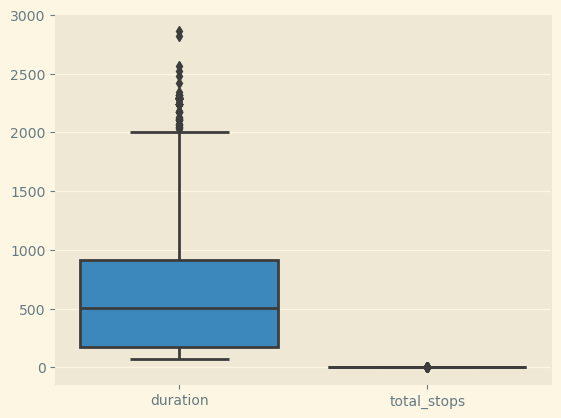

In [246]:
sns.boxplot(data=df.drop(['price'], axis = 1))

In [247]:
Q1 = df['duration'].quantile(0.25)
Q3 = df['duration'].quantile(0.75)
print(f"Q1 :- {Q1} || Q2:-{Q3}")
IQR = Q3 - Q1
print("IQR:-",IQR)
lower_bound = Q1 - 1.5*IQR
upper_bound = Q3 + 1.5*IQR
print(f"lower_bound :- {lower_bound} || upper_bound:- {upper_bound}")


outliers = df[(df['duration'] <lower_bound) | (df['duration'] > upper_bound)]

Q1 :- 170.0 || Q2:-910.0
IQR:- 740.0
lower_bound :- -940.0 || upper_bound:- 2020.0


In [248]:
outliers.shape

(75, 11)

In [255]:
outliers

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,class
226,Jet Airways,2019-03-03,Delhi,Cochin,2024-09-04 05:25:00,2024-09-04 18:50:00,2245,2,No Info,18799,Economy
470,Jet Airways,2019-03-21,Delhi,Cochin,2024-09-04 18:20:00,2024-09-04 04:25:00,2045,2,No Info,13082,Economy
553,Air India,2019-03-09,Delhi,Cochin,2024-09-04 05:00:00,2024-09-04 19:15:00,2295,2,No Info,10598,Economy
918,Air India,2019-05-12,Kolkata,Banglore,2024-09-04 12:00:00,2024-09-04 23:15:00,2115,3,No Info,10991,Economy
924,Jet Airways,2019-03-06,Delhi,Cochin,2024-09-04 16:50:00,2024-09-04 04:25:00,2135,2,No Info,19907,Economy
...,...,...,...,...,...,...,...,...,...,...,...
9526,Air India,2019-03-03,Delhi,Cochin,2024-09-04 05:55:00,2024-09-04 19:15:00,2240,2,No Info,13748,Economy
9831,Air India,2019-05-09,Delhi,Cochin,2024-09-04 05:00:00,2024-09-04 19:15:00,2295,2,No Info,9653,Economy
10121,Air India,2019-03-03,Banglore,New Delhi,2024-09-04 05:50:00,2024-09-04 22:10:00,2420,2,No Info,11791,Economy
10247,Jet Airways,2019-03-06,Delhi,Cochin,2024-09-04 19:10:00,2024-09-04 18:50:00,2860,2,No Info,20694,Economy


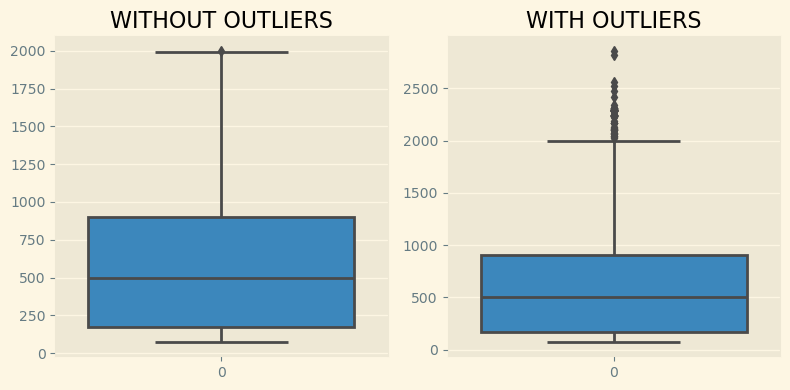

In [251]:
df_no_outliers = df[(df['duration'] >= lower_bound) & (df['duration'] <= upper_bound)]

fig, axs = plt.subplots(1, 2, figsize = (8, 4))

sns.boxplot(data=df_no_outliers['duration'], ax = axs[0])
axs[0].set_title("WITHOUT OUTLIERS")

sns.boxplot(data=df['duration'], ax = axs[1])
axs[1].set_title("WITH OUTLIERS")

plt.tight_layout()
plt.show()

In [272]:
N_O = df_no_outliers[(df_no_outliers['source'] == 'Delhi') & (df_no_outliers['destination'] == 'Cochin')]['price'].mean()
O = outliers[(outliers['source'] == 'Delhi') & (outliers['destination'] == 'Cochin')]['price'].mean()
ALL = df[(df['source'] == 'Delhi') & (df['destination'] == 'Cochin')]['price'].mean()
print(f"No outlier price between Delhi to Cochin :-{N_O}")
print(f"Outlier price between Delhi to Cochin :-{O}")
print('-'*60)
print(f"Overall price between Delhi to Cochin :-{ALL}")

No outlier price between Delhi to Cochin :-10434.607975746268
Outlier price between Delhi to Cochin :-12405.793103448275
------------------------------------------------------------
Overall price between Delhi to Cochin :-10460.914634146342


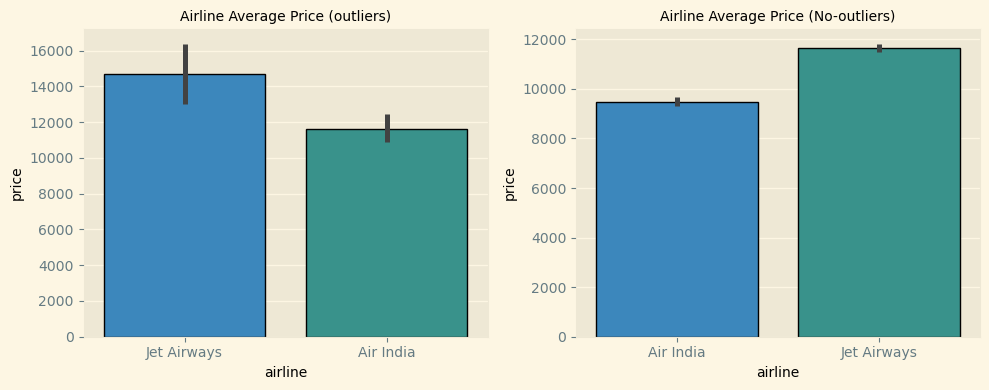

In [290]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.barplot(data=outliers, x='airline', y='price', edgecolor='black', ax=ax[0])
ax[0].set_title("Airline Average Price (outliers)", size=10)
sns.barplot(data=df_no_outliers[(df_no_outliers['airline'] == 'Jet Airways') | (df_no_outliers['airline'] == 'Air India')],
            x='airline',
            y = 'price',
            edgecolor='black',
            ax=ax[1]
           )
ax[1].set_title("Airline Average Price (No-outliers)", size=10)
plt.tight_layout()
plt.show()

In [293]:
print("UNIQUE CLASS IN OUTLIER DATA :-",outliers['class'].unique())

UNIQUE CLASS IN OUTLIER DATA :- ['Economy']


In [ ]:
# All through the data in the outlier belongs to the same class there are significant difference between the normal price and 
# outlier price.Therefore we can conclude that the values in outlier are actually an outlier and should be removed.

In [295]:
df = df_no_outliers

In [94]:
# using INTERQUARTILE RANGE we are not getting any outlier

In [304]:
df['price'].describe()

count    10387.000000
mean      8999.835082
std       4620.566100
min       1759.000000
25%       5201.000000
50%       8146.000000
75%      12313.000000
max      79512.000000
Name: price, dtype: float64

In [302]:
outliers['price'].describe()

count       75.000000
mean     12628.613333
std       3617.652337
min       7711.000000
25%      10493.000000
50%      11552.000000
75%      13947.000000
max      25430.000000
Name: price, dtype: float64

## PAIR-PLOTS

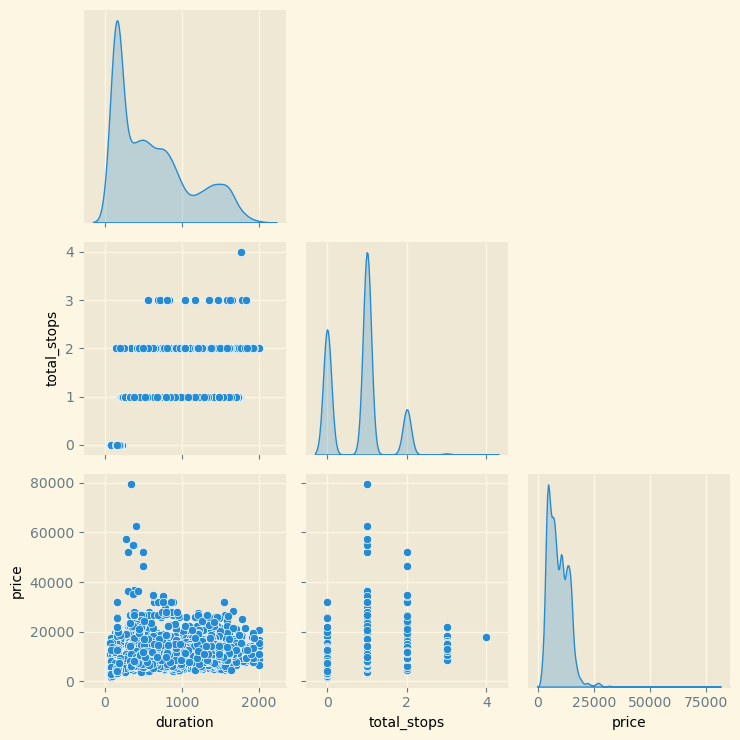

In [296]:
sns.pairplot(data=df, corner=True,  diag_kind='kde')
plt.tight_layout()
plt.show()

In [297]:
cm = df.corr(method = 'spearman', numeric_only=True)
mask = np.triu(np.ones_like(cm, dtype=bool))
mask

array([[ True,  True,  True],
       [False,  True,  True],
       [False, False,  True]])

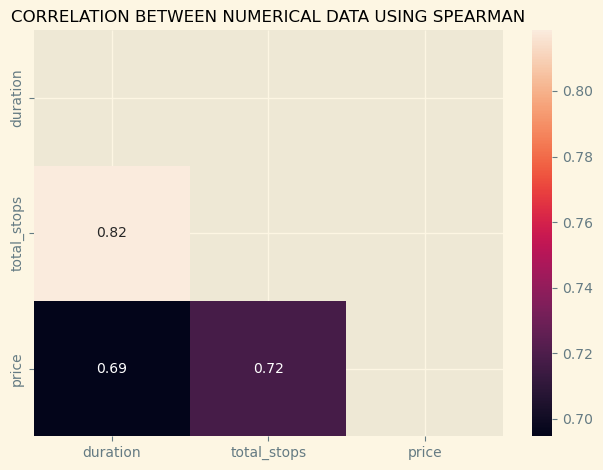

In [298]:
sns.heatmap(cm, mask = mask, annot=True)

plt.title("CORRELATION BETWEEN NUMERICAL DATA USING SPEARMAN", size = 12)
plt.tight_layout()
plt.show()

In [ ]:
# So by using spearman techniques we can identify significant correlations among multiple numerical data.
# It's important to take this correlation into account when training a machine learning model.

In [ ]:
cm = df.corr(method = 'spearman', numeric_only=True)


## DETAILED ANALYSIS

In [305]:
df.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price',
       'class'],
      dtype='object')

### AIRLINE

In [306]:
df['airline'].describe()

count           10387
unique              9
top       Jet Airways
freq             3681
Name: airline, dtype: object

In [307]:
df['airline'].value_counts(normalize=True)

airline
Jet Airways          0.354385
IndiGo               0.196688
Air India            0.158275
Multiple carriers    0.116395
SpiceJet             0.078463
Vistara              0.046308
Air Asia             0.030711
GoAir                0.018677
Trujet               0.000096
Name: proportion, dtype: float64

#### UNIVARIATE ANALYSIS

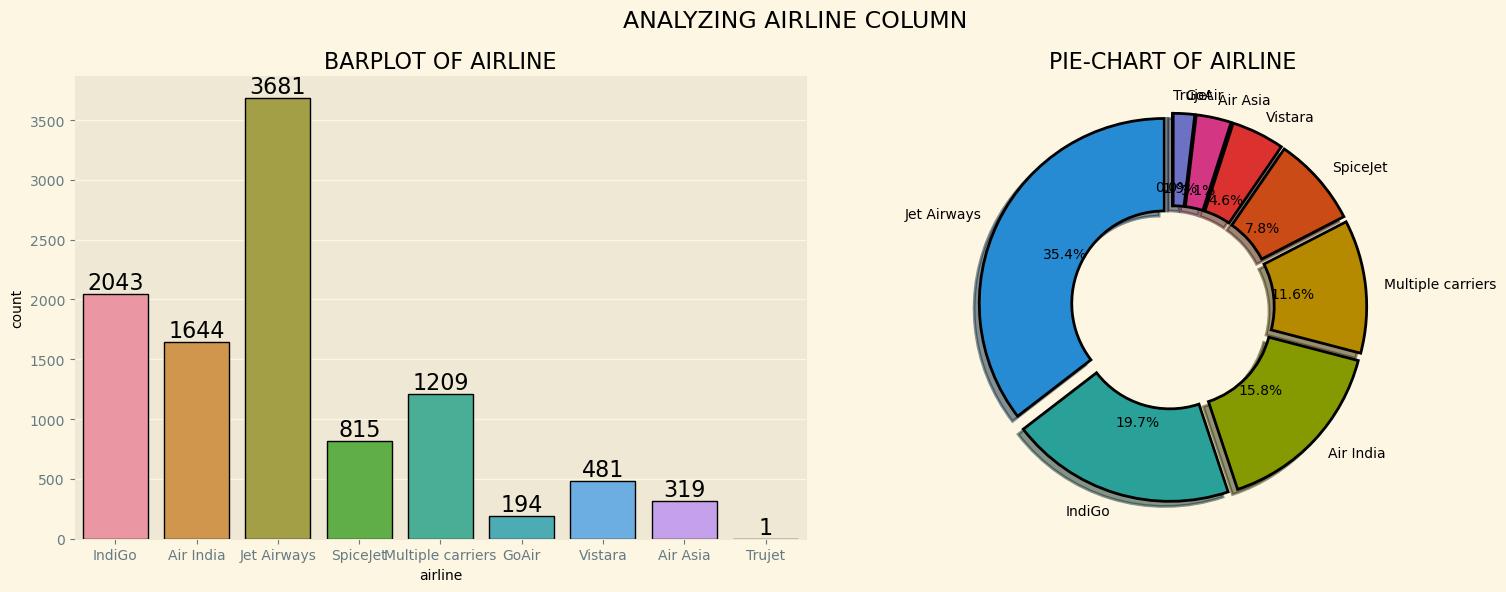

In [308]:
f, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(data=df, x='airline',ax=ax[0], edgecolor='black')
for container in ax[0].containers:
    ax[0].bar_label(container, color='black', size=16)
ax[0].set_title("BARPLOT OF AIRLINE")   

ax[1].pie(x=df['airline'].value_counts(),
          labels=df['airline'].value_counts().index,
         explode=[0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05],
         autopct='%1.1f%%',
        shadow=True,
        startangle=90, 
        wedgeprops={'edgecolor':'black', 'linewidth':2, 'width':0.5})

ax[1].set_title("PIE-CHART OF AIRLINE")

plt.suptitle("ANALYZING AIRLINE COLUMN", size=17)
plt.tight_layout()
plt.show()

#### BIVARIATE ANALYSIS

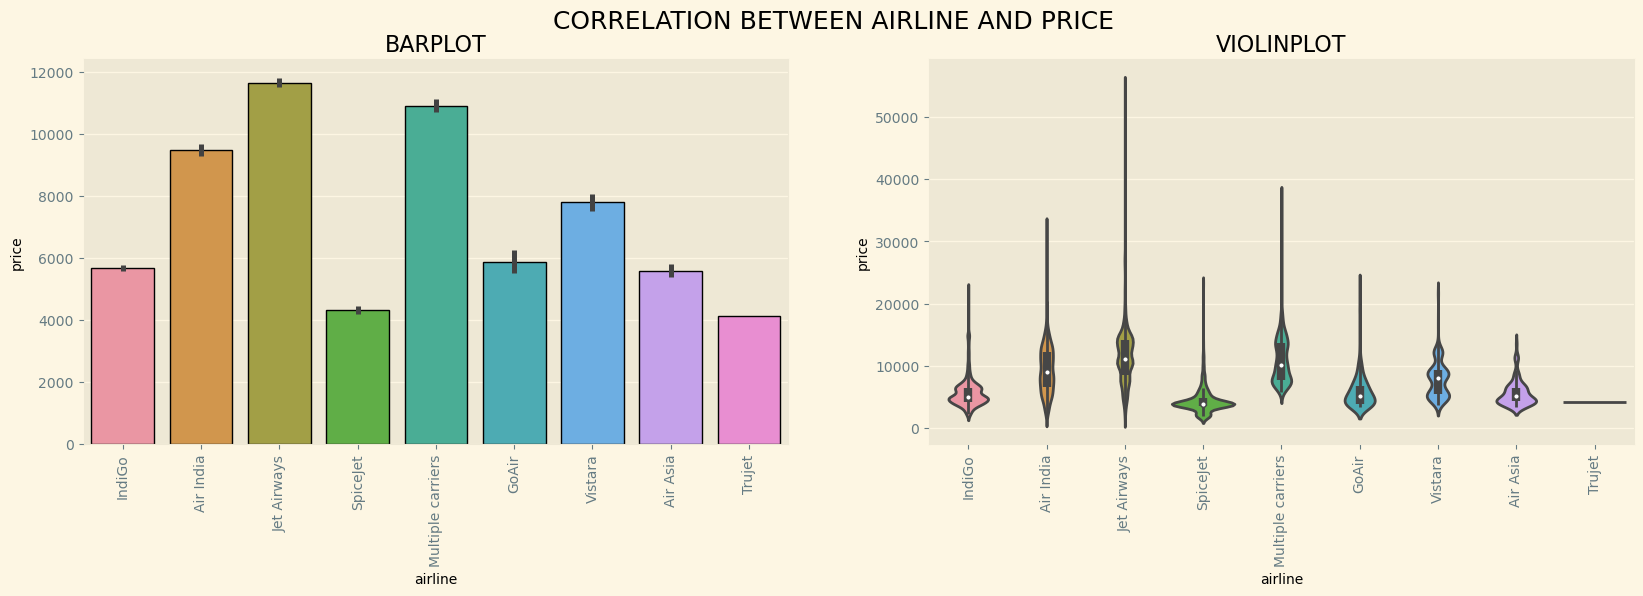

In [321]:
f, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot(data=df, x='airline', y='price', edgecolor='black',ax=ax[0])
ax[0].set_xticklabels(df['airline'].unique(), rotation=90) 
ax[0].set_title('BARPLOT')
sns.violinplot(data=df[df['class'] == 'Economy'], x='airline', y='price', showfliers=True, ax=ax[1])
ax[1].set_title("VIOLINPLOT")
ax[1].set_xticklabels(df['airline'].unique(), rotation=90)
plt.suptitle("CORRELATION BETWEEN AIRLINE AND PRICE", fontsize = 18)
plt.show()

### DATE OF JOURNEY COLUMN

In [342]:
df['date_of_journey']

0       2019-03-24
1       2019-05-01
2       2019-06-09
3       2019-05-12
4       2019-03-01
           ...    
10457   2019-04-09
10458   2019-04-27
10459   2019-04-27
10460   2019-03-01
10461   2019-05-09
Name: date_of_journey, Length: 10387, dtype: datetime64[ns]

In [345]:
df['date_of_journey'].sort_values().unique()

<DatetimeArray>
['2019-03-01 00:00:00', '2019-03-03 00:00:00', '2019-03-06 00:00:00',
 '2019-03-09 00:00:00', '2019-03-12 00:00:00', '2019-03-15 00:00:00',
 '2019-03-18 00:00:00', '2019-03-21 00:00:00', '2019-03-24 00:00:00',
 '2019-03-27 00:00:00', '2019-04-01 00:00:00', '2019-04-03 00:00:00',
 '2019-04-06 00:00:00', '2019-04-09 00:00:00', '2019-04-12 00:00:00',
 '2019-04-15 00:00:00', '2019-04-18 00:00:00', '2019-04-21 00:00:00',
 '2019-04-24 00:00:00', '2019-04-27 00:00:00', '2019-05-01 00:00:00',
 '2019-05-03 00:00:00', '2019-05-06 00:00:00', '2019-05-09 00:00:00',
 '2019-05-12 00:00:00', '2019-05-15 00:00:00', '2019-05-18 00:00:00',
 '2019-05-21 00:00:00', '2019-05-24 00:00:00', '2019-05-27 00:00:00',
 '2019-06-01 00:00:00', '2019-06-03 00:00:00', '2019-06-06 00:00:00',
 '2019-06-09 00:00:00', '2019-06-12 00:00:00', '2019-06-15 00:00:00',
 '2019-06-18 00:00:00', '2019-06-21 00:00:00', '2019-06-24 00:00:00',
 '2019-06-27 00:00:00']
Length: 40, dtype: datetime64[ns]

### UNIVARIATE ANALYSIS

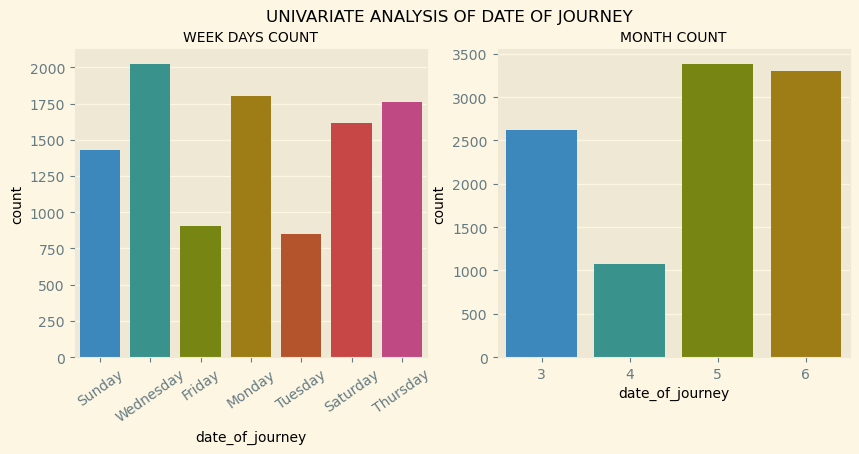

In [365]:
f, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.countplot(x=df['date_of_journey'].dt.day_name(), ax=ax[0])
ax[0].set_xticklabels(df['date_of_journey'].dt.day_name().unique(), rotation=35)
ax[0].set_title("WEEK DAYS COUNT", size=10)
sns.countplot(x=df['date_of_journey'].dt.month, ax=ax[1])
ax[1].set_title("MONTH COUNT", size=10)
plt.suptitle("UNIVARIATE ANALYSIS OF DATE OF JOURNEY")
plt.show()

### BIVARIATE ANALYSIS

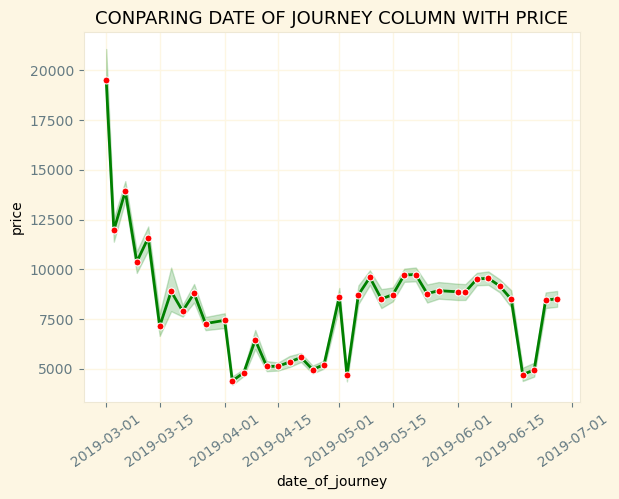

In [434]:
sns.lineplot(data=df, x='date_of_journey', y='price', marker='o', color='green'
                                             , markersize=5, markerfacecolor='red')
plt.xticks(rotation=35)
plt.gca().set_facecolor('white')
plt.title("CONPARING DATE OF JOURNEY COLUMN WITH PRICE", size=13)
plt.show()

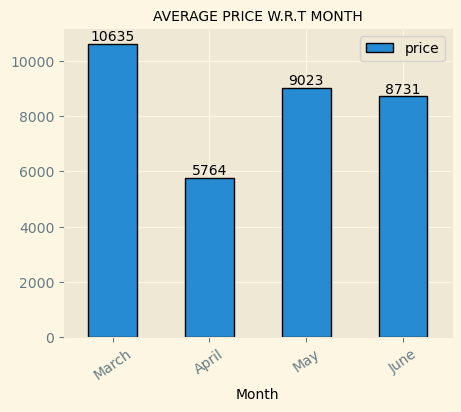

In [397]:
(
    df
    .groupby(pd.Grouper(key='date_of_journey', freq='M'))
    .price.mean()
    .to_frame()
    .set_axis(['March', "April", "May", "June"])
    .rename_axis(index="Month")
    .plot(kind='bar', figsize=(5, 4), edgecolor='black')
)
ax = plt.gca()
ax.set_xticklabels(['March', "April", "May", "June"], rotation=35)
add_bar_labels(ax)
ax.set_title("AVERAGE PRICE W.R.T MONTH", size=10)
plt.show()


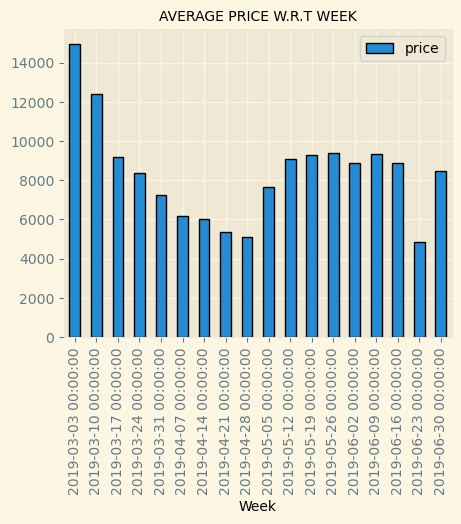

In [402]:
(
    df
    .groupby(pd.Grouper(key='date_of_journey', freq='W'))
    .price.mean()
    .to_frame()
    .rename_axis(index="Week")
    .plot(kind='bar', figsize=(5, 4), edgecolor='black')
)
ax = plt.gca()
ax.set_title("AVERAGE PRICE W.R.T WEEK", size=10)
plt.show()


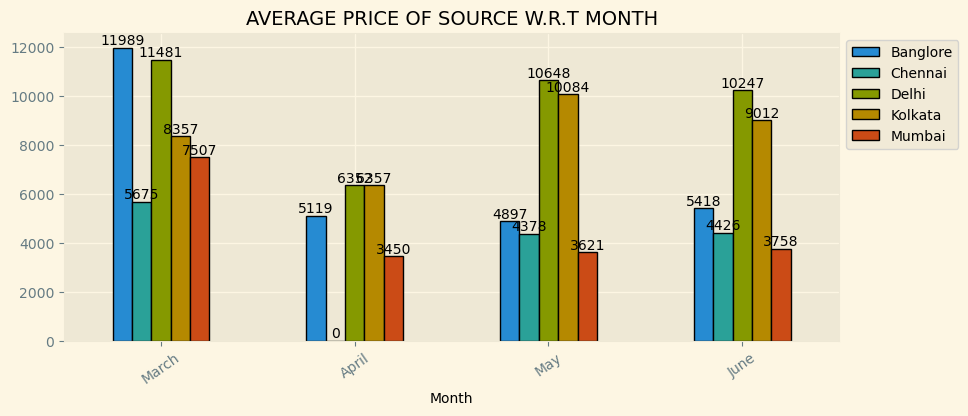

In [427]:
(
    df
    .groupby([pd.Grouper(key='date_of_journey', freq='M'), 'source'])
    .price.mean()
    .unstack(fill_value=0)
    .set_axis(['March', 'April', 'May', 'June'])
    .rename_axis(index='Month')
    .plot(kind='bar', edgecolor='black', figsize=(10, 4))
)
ax = plt.gca()
ax.set_xticklabels(['March', "April", "May", "June"], rotation=35)
add_bar_labels(ax)
ax.set_title("AVERAGE PRICE OF SOURCE W.R.T MONTH", size=14)
ax.legend(
    loc='upper left',
    bbox_to_anchor = (1, 1)
)
plt.show()


In [405]:
df.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price',
       'class'],
      dtype='object')

### DEPARTURE TIME

In [428]:
df['dep_time'].dt.time

0        22:20:00
1        05:50:00
2        09:25:00
3        18:05:00
4        16:50:00
           ...   
10457    19:55:00
10458    20:45:00
10459    08:20:00
10460    11:30:00
10461    10:55:00
Name: dep_time, Length: 10387, dtype: object

### UNIVARIATE ANALYSIS

Text(0.5, 1.0, 'COUNTPLOT OF DEPARTURE TIME W.R.T. HRS')

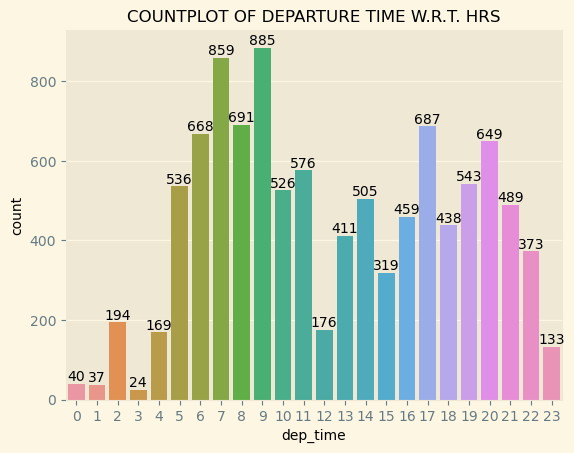

In [444]:
sns.countplot(x=df['dep_time'].dt.hour)
ax=plt.gca()
add_bar_labels(ax)
plt.title("COUNTPLOT OF DEPARTURE TIME W.R.T. HRS", size=12)

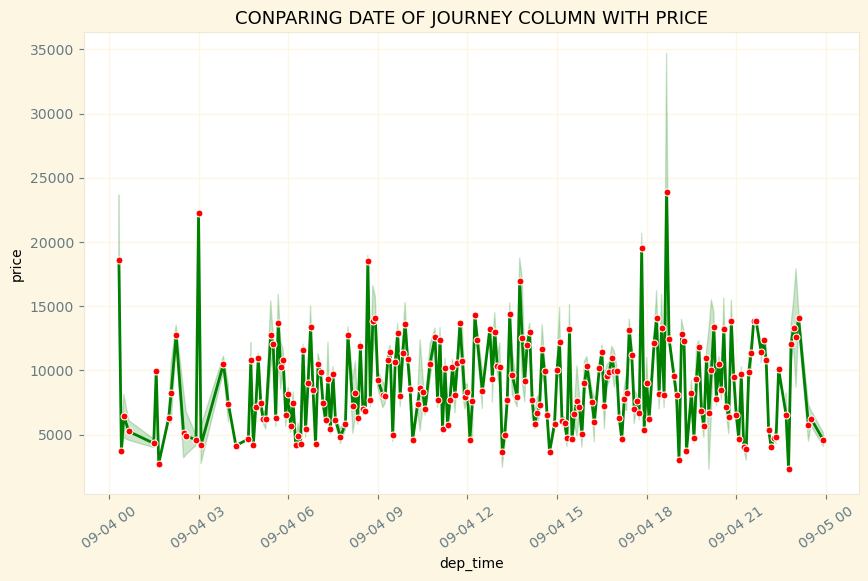

In [446]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='dep_time', y='price', marker='o', color='green'
                                             , markersize=5, markerfacecolor='red')
plt.xticks(rotation=35)
plt.gca().set_facecolor('white')
plt.title("CONPARING DATE OF JOURNEY COLUMN WITH PRICE", size=13)
plt.show()

In [453]:
df_dep_time = (
    df
    .assign(dep_time=lambda df_:(
        np.select([df_.dep_time.dt.hour.between(4, 12, inclusive='left'),
                   df_.dep_time.dt.hour.between(12, 16, inclusive = 'left'),
                   df_.dep_time.dt.hour.between(16, 20, inclusive = 'left')],
                  ["Morning", "Afternoon", "Evening"],
                  default = 'Night')
    ))
    
)
df_dep_time

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price,class
0,IndiGo,2019-03-24,Banglore,New Delhi,Night,2024-09-04 01:10:00,170,0,No Info,3897,Economy
1,Air India,2019-05-01,Kolkata,Banglore,Morning,2024-09-04 13:15:00,445,2,No Info,7662,Economy
2,Jet Airways,2019-06-09,Delhi,Cochin,Morning,2024-09-04 04:25:00,1140,2,No Info,13882,Economy
3,IndiGo,2019-05-12,Kolkata,Banglore,Evening,2024-09-04 23:30:00,325,1,No Info,6218,Economy
4,IndiGo,2019-03-01,Banglore,New Delhi,Evening,2024-09-04 21:35:00,285,1,No Info,13302,Economy
...,...,...,...,...,...,...,...,...,...,...,...
10457,Air Asia,2019-04-09,Kolkata,Banglore,Evening,2024-09-04 22:25:00,150,0,No Info,4107,Economy
10458,Air India,2019-04-27,Kolkata,Banglore,Night,2024-09-04 23:20:00,155,0,No Info,4145,Economy
10459,Jet Airways,2019-04-27,Banglore,Delhi,Morning,2024-09-04 11:20:00,180,0,No Info,7229,Economy
10460,Vistara,2019-03-01,Banglore,New Delhi,Morning,2024-09-04 14:10:00,160,0,No Info,12648,Economy


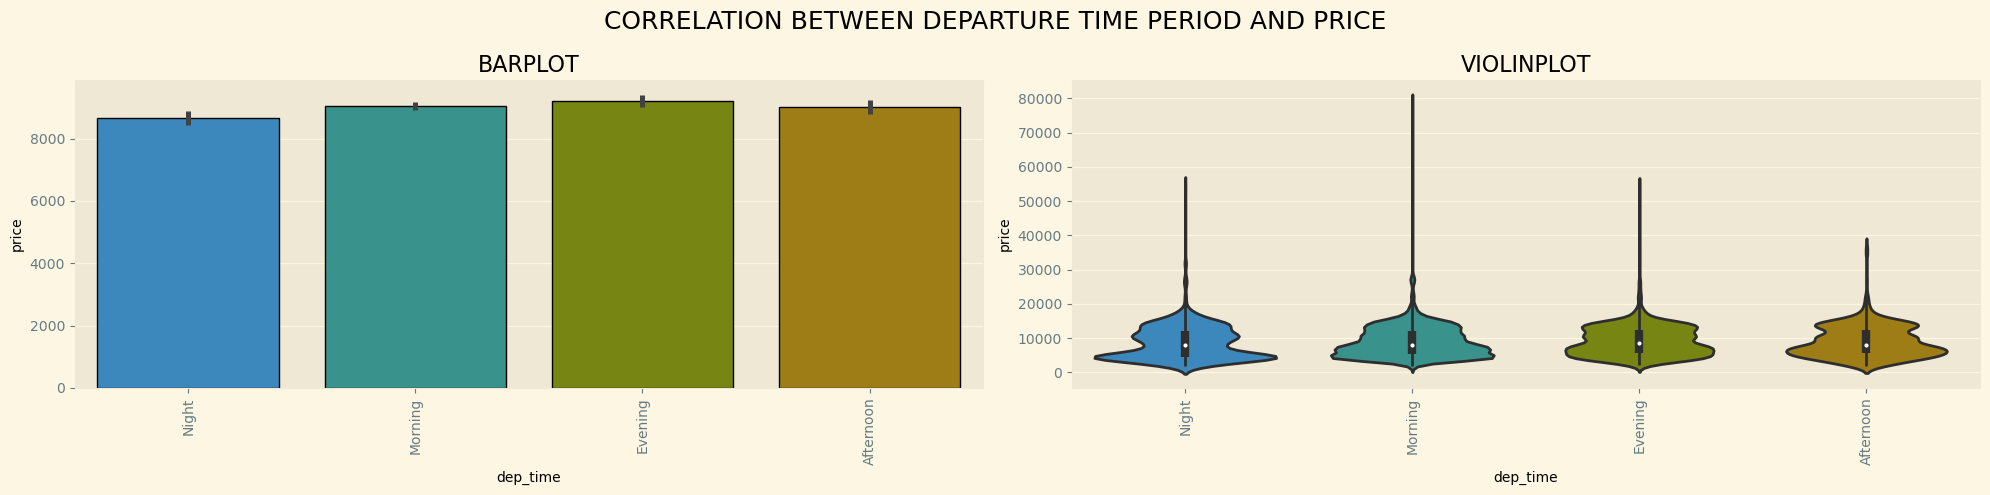

In [456]:
f, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot(data=df_dep_time, x='dep_time', y='price', edgecolor='black',ax=ax[0])
ax[0].set_xticklabels(df_dep_time['dep_time'].unique(), rotation=90) 
ax[0].set_title('BARPLOT')
sns.violinplot(data=df_dep_time, x='dep_time', y='price', showfliers=True, ax=ax[1])
ax[1].set_title("VIOLINPLOT")
ax[1].set_xticklabels(df_dep_time['dep_time'].unique(), rotation=90)
plt.suptitle("CORRELATION BETWEEN DEPARTURE TIME PERIOD AND PRICE", fontsize = 18)
plt.tight_layout()
plt.show()

In [457]:
df.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price',
       'class'],
      dtype='object')

### ARRIVAL TIME

In [458]:
df['arrival_time']

0       2024-09-04 01:10:00
1       2024-09-04 13:15:00
2       2024-09-04 04:25:00
3       2024-09-04 23:30:00
4       2024-09-04 21:35:00
                ...        
10457   2024-09-04 22:25:00
10458   2024-09-04 23:20:00
10459   2024-09-04 11:20:00
10460   2024-09-04 14:10:00
10461   2024-09-04 19:15:00
Name: arrival_time, Length: 10387, dtype: datetime64[ns]

### UNIVARIATE ANALYSIS

Text(0.5, 1.0, 'COUNTPLOT OF ARRIVAL TIME W.R.T. HRS')

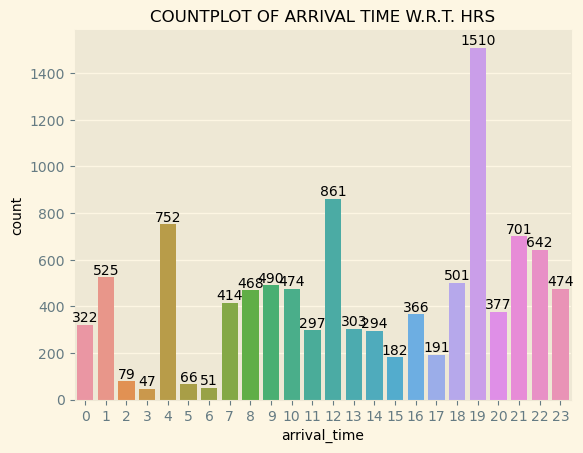

In [459]:
sns.countplot(x=df['arrival_time'].dt.hour)
ax=plt.gca()
add_bar_labels(ax)
plt.title("COUNTPLOT OF ARRIVAL TIME W.R.T. HRS", size=12)

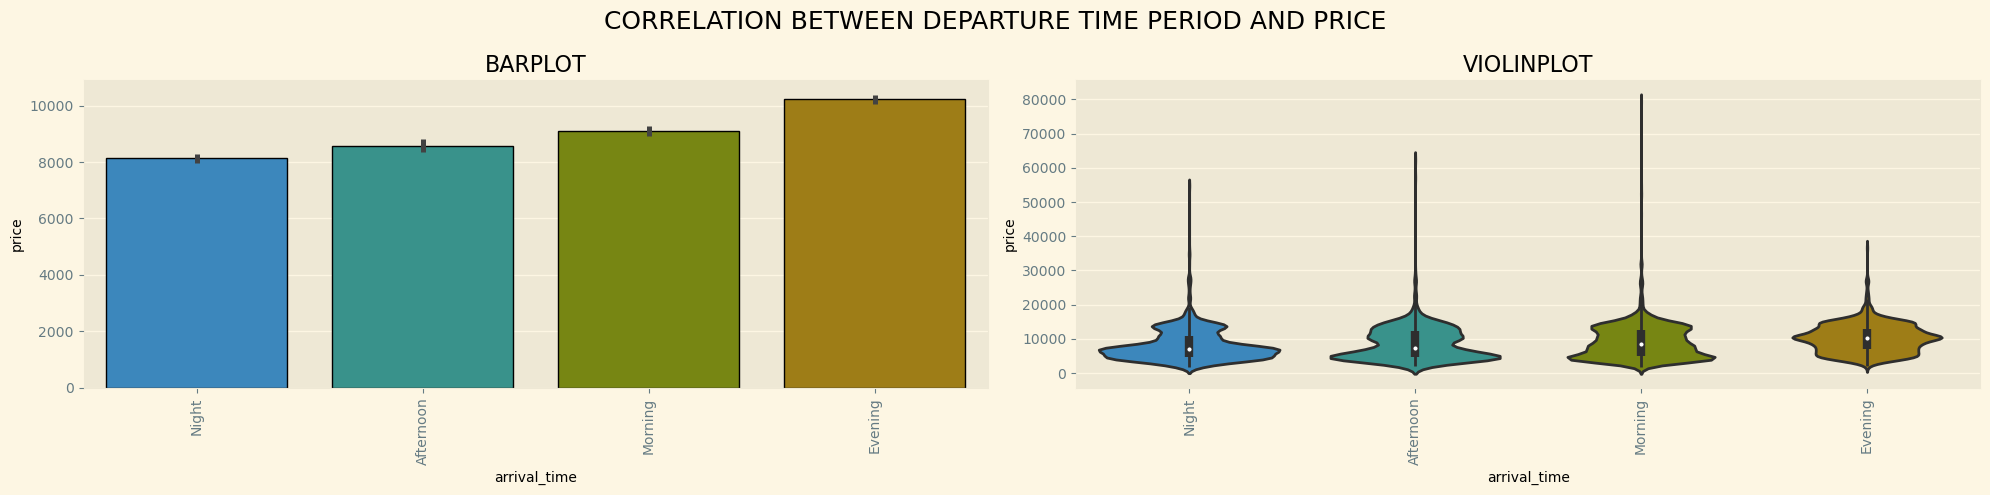

In [462]:
df_arrival_time = (
    df
    .assign(arrival_time=lambda df_:(
        np.select([df_.arrival_time.dt.hour.between(4, 12, inclusive='left'),
                   df_.arrival_time.dt.hour.between(12, 16, inclusive = 'left'),
                   df_.arrival_time.dt.hour.between(16, 20, inclusive = 'left')],
                  ["Morning", "Afternoon", "Evening"],
                  default = 'Night')
    ))
    
)
df_arrival_time

f, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.barplot(data=df_arrival_time, x='arrival_time', y='price', edgecolor='black',ax=ax[0])
ax[0].set_xticklabels(df_arrival_time['arrival_time'].unique(), rotation=90) 
ax[0].set_title('BARPLOT')
sns.violinplot(data=df_arrival_time, x='arrival_time', y='price', showfliers=True, ax=ax[1])
ax[1].set_title("VIOLINPLOT")
ax[1].set_xticklabels(df_arrival_time['arrival_time'].unique(), rotation=90)
plt.suptitle("CORRELATION BETWEEN DEPARTURE TIME PERIOD AND PRICE", fontsize = 18)
plt.tight_layout()
plt.show()

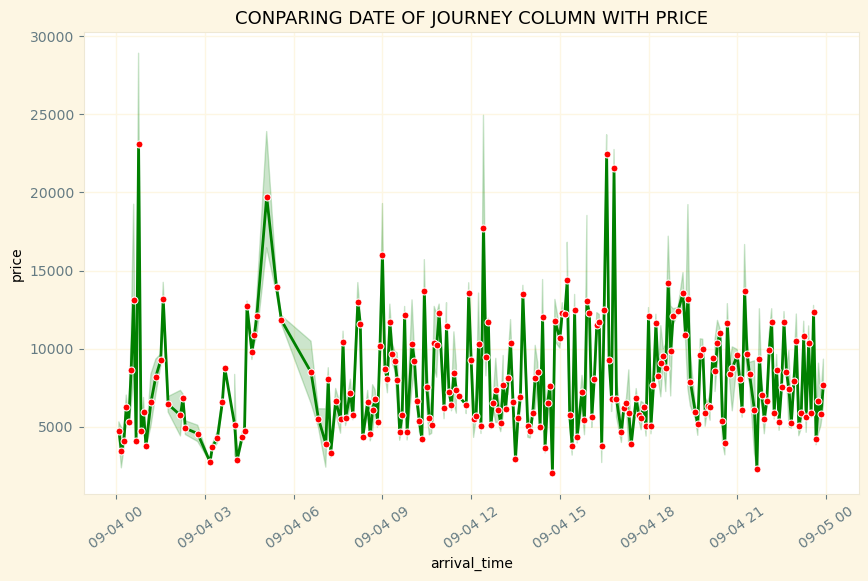

In [460]:
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x='arrival_time', y='price', marker='o', color='green'
                                             , markersize=5, markerfacecolor='red')
plt.xticks(rotation=35)
plt.gca().set_facecolor('white')
plt.title("CONPARING DATE OF JOURNEY COLUMN WITH PRICE", size=13)
plt.show()

## DURATION

In [464]:
df['duration']

0         170
1         445
2        1140
3         325
4         285
         ... 
10457     150
10458     155
10459     180
10460     160
10461     500
Name: duration, Length: 10387, dtype: int64

In [465]:
df['duration'].describe()

count    10387.000000
mean       618.166458
std        482.832048
min         75.000000
25%        170.000000
50%        500.000000
75%        900.000000
max       2000.000000
Name: duration, dtype: float64

<Axes: xlabel='duration', ylabel='Density'>

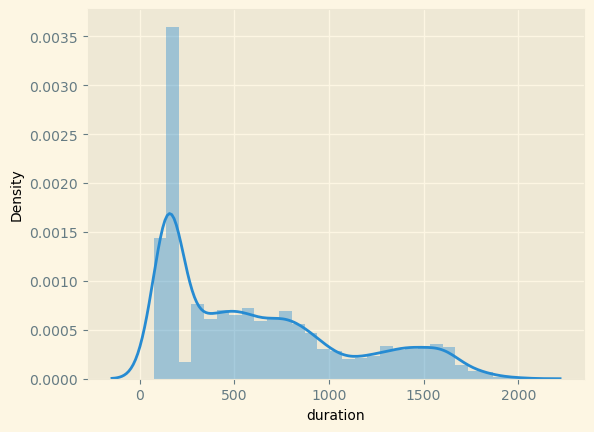

In [472]:
sns.distplot(df['duration'])

<Axes: xlabel='duration', ylabel='price'>

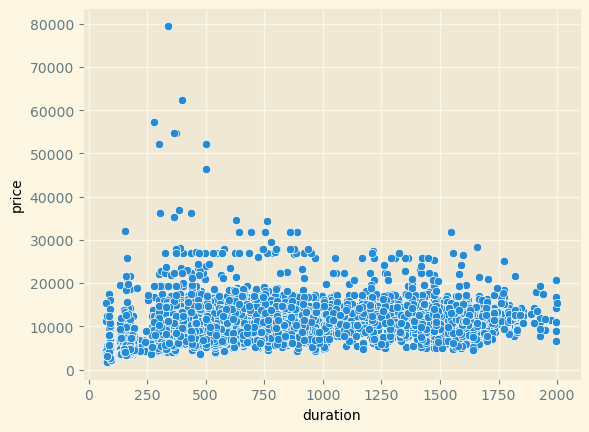

In [473]:
sns.scatterplot(data=df, x='duration', y='price')

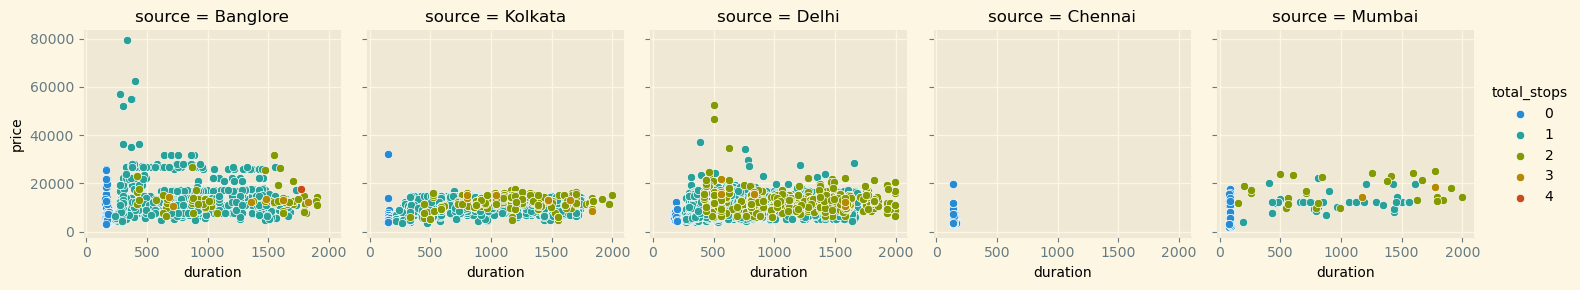

In [474]:
duration_grid = sns.FacetGrid(
    data=df,
    col="source",
    hue="total_stops",
    sharey=True
)

duration_grid.map(sns.scatterplot, "duration", "price")

duration_grid.add_legend()

In [475]:
df.columns

Index(['airline', 'date_of_journey', 'source', 'destination', 'dep_time',
       'arrival_time', 'duration', 'total_stops', 'additional_info', 'price',
       'class'],
      dtype='object')

In [477]:
df['total_stops'].unique()

array([0, 2, 1, 3, 4], dtype=int64)

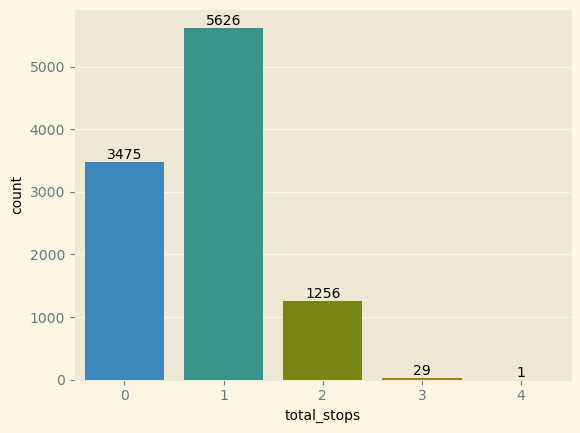

In [479]:
sns.countplot(data=df, x='total_stops')
ax = plt.gca()
add_bar_labels(ax)

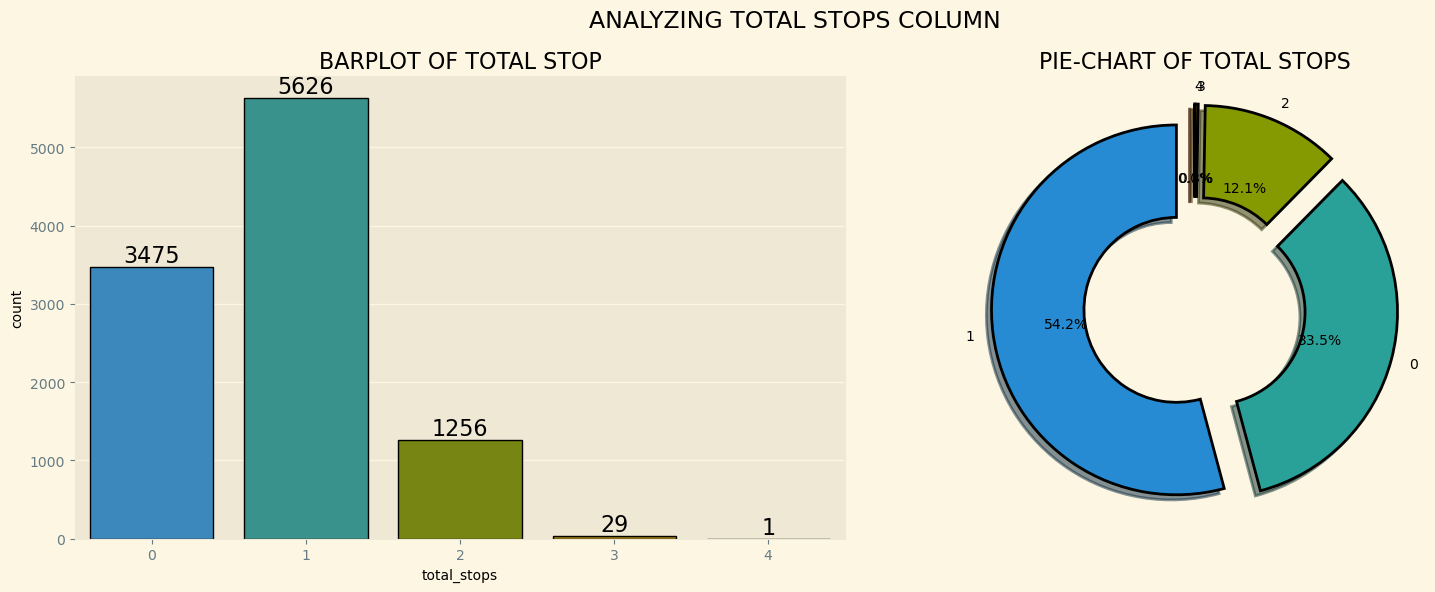

In [491]:
f, ax = plt.subplots(1, 2, figsize=(16, 6))
sns.countplot(data=df, x='total_stops',ax=ax[0], edgecolor='black')
for container in ax[0].containers:
    ax[0].bar_label(container, color='black', size=16)
ax[0].set_title("BARPLOT OF TOTAL STOP")   

ax[1].pie(x=df['total_stops'].value_counts(),
          labels=df['total_stops'].value_counts().index,
         explode=[0.1, 0.1, 0.1, 0.1, 0.1],
         autopct='%1.1f%%',
        shadow=True,
        startangle=90, 
        wedgeprops={'edgecolor':'black', 'linewidth':2, 'width':0.5})

ax[1].set_title("PIE-CHART OF TOTAL STOPS")

plt.suptitle("ANALYZING TOTAL STOPS COLUMN", size=17)
plt.tight_layout()
plt.show()

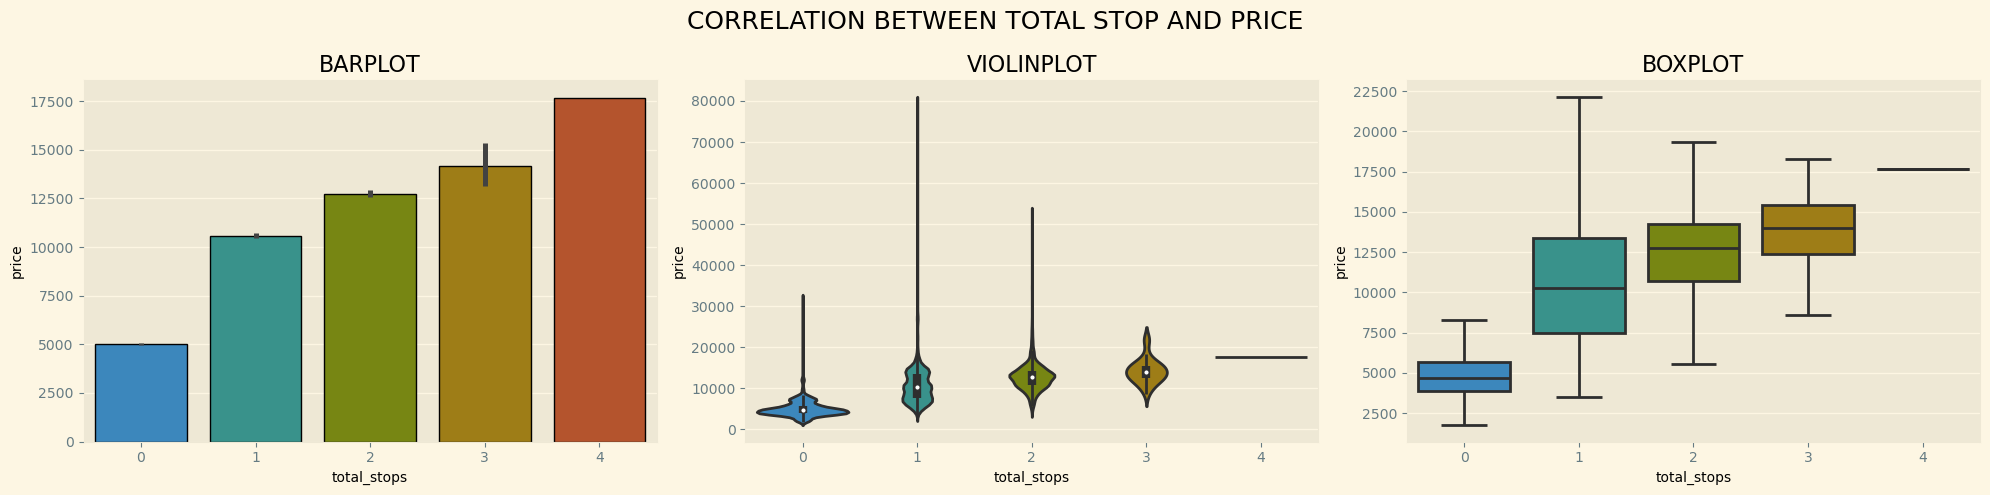

In [527]:
f, ax = plt.subplots(2, 2, figsize=(20, 5))
sns.barplot(data=df, x='total_stops', y='price', edgecolor='black',ax=ax[0])
ax[0].set_title('BARPLOT')
sns.violinplot(data=df, x='total_stops', y='price', showfliers=True, ax=ax[1])
ax[1].set_title("VIOLINPLOT")
sns.boxplot(data=df, x='total_stops', y='price', showfliers=False, ax=ax[2])
ax[2].set_title("BOXPLOT")
sns.scatterplot(data=df[df['class']=='Economy'], y='price', x='total_stops', ax=ax[3])
plt.suptitle("CORRELATION BETWEEN TOTAL STOP AND PRICE", fontsize = 18)
plt.tight_layout()
plt.show()

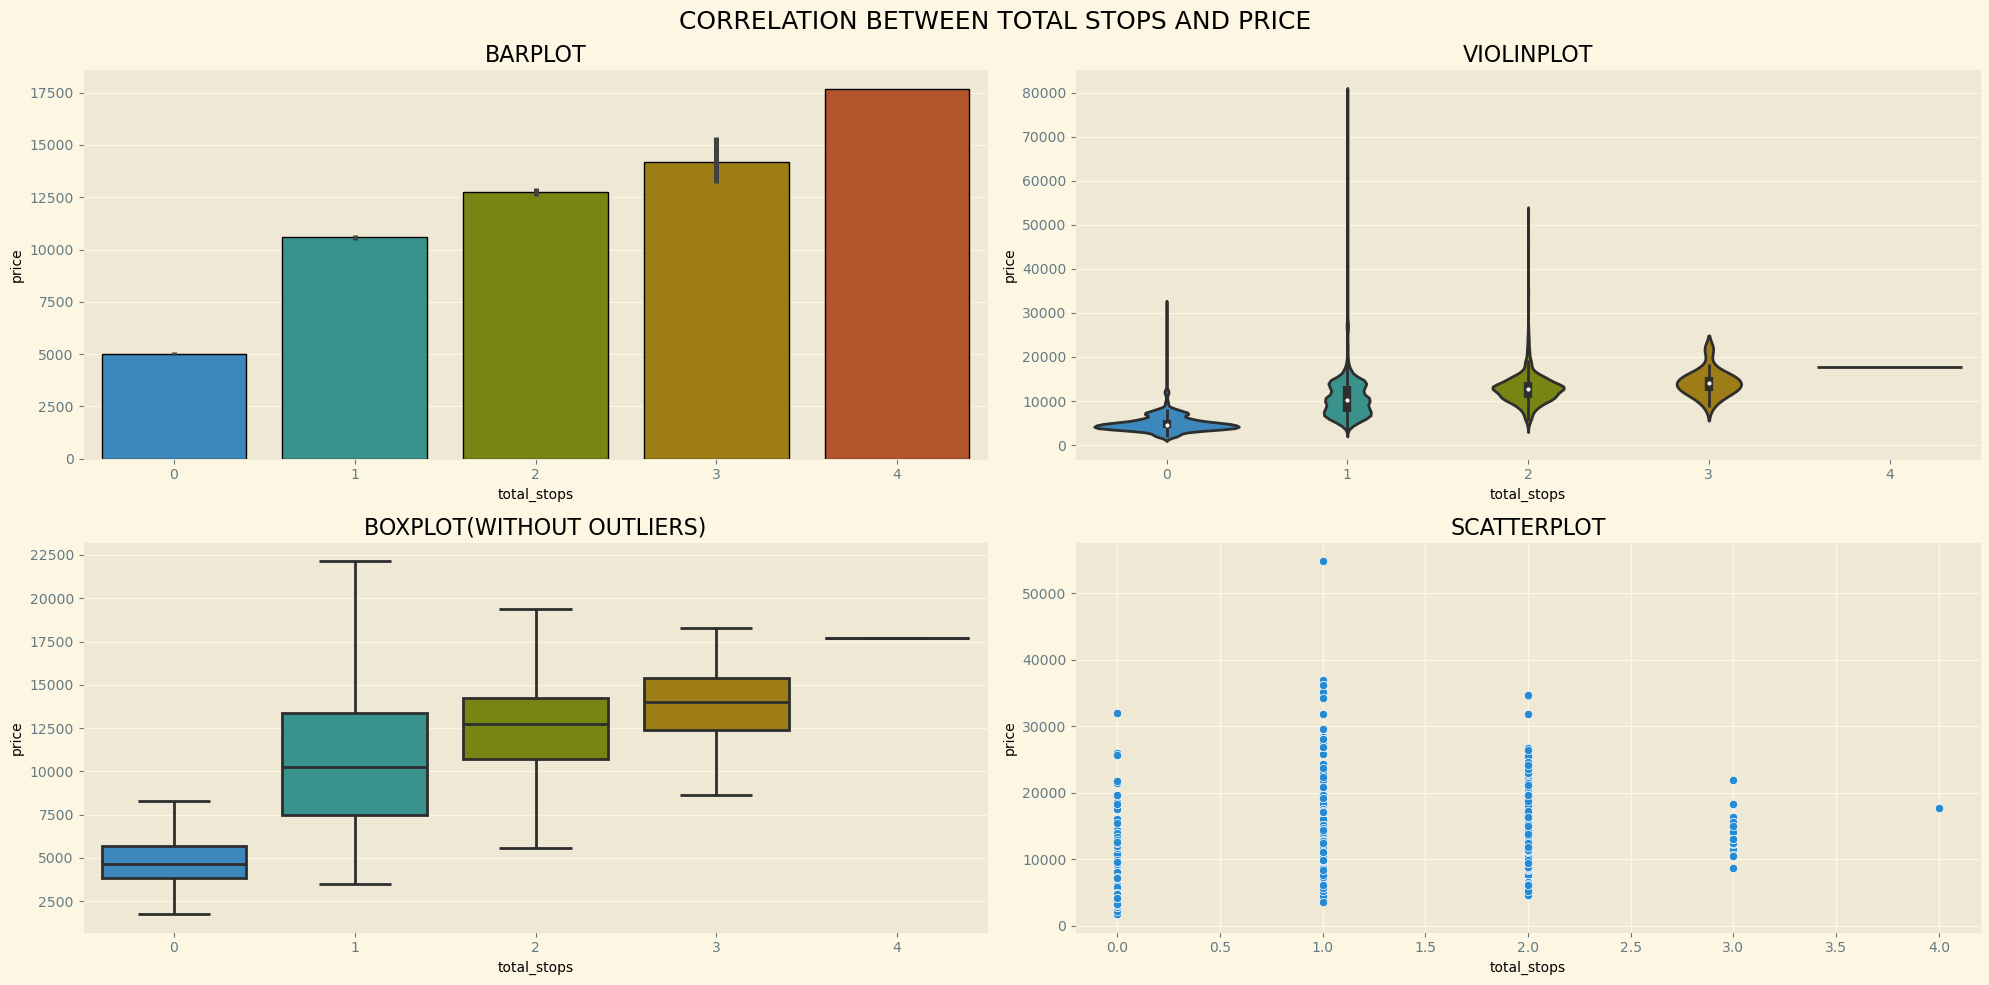

In [530]:
f, ax = plt.subplots(2, 2, figsize=(20, 10))
sns.barplot(data=df, x='total_stops', y='price', edgecolor='black', ax=ax[0, 0])
ax[0, 0].set_title('BARPLOT')
sns.violinplot(data=df, x='total_stops', y='price', showfliers=True, ax=ax[0, 1])
ax[0, 1].set_title("VIOLINPLOT")
sns.boxplot(data=df, x='total_stops', y='price', showfliers=False, ax=ax[1, 0])
ax[1, 0].set_title("BOXPLOT(WITHOUT OUTLIERS)")
sns.scatterplot(data=df[df['class']=='Economy'], x='total_stops', y='price', ax=ax[1, 1])
ax[1, 1].set_title("SCATTERPLOT")
plt.suptitle("CORRELATION BETWEEN TOTAL STOPS AND PRICE", fontsize=18)
plt.subplots_adjust(top=0.9)  
plt.tight_layout()
plt.show()


## ADDITIONAL INFO

In [503]:
df['additional_info'].unique()

array(['No Info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

In [504]:
df['additional_info'].value_counts()

additional_info
No Info                         8118
In-flight meal not included     1918
No check-in baggage included     318
1 Long layover                    19
Change airports                    7
Business class                     4
1 Short layover                    1
Red-eye flight                     1
2 Long layover                     1
Name: count, dtype: int64

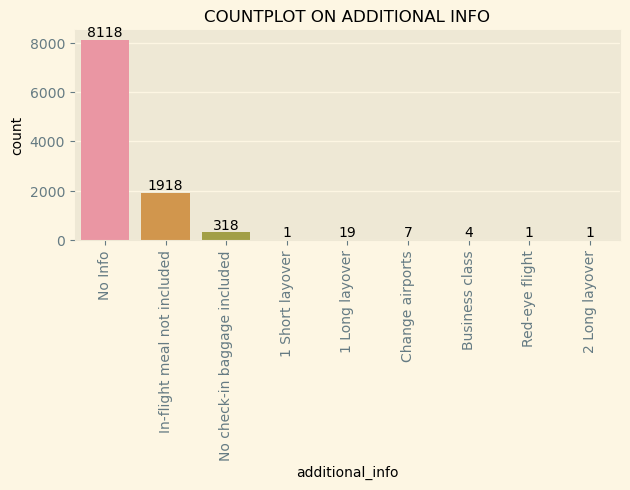

In [532]:
sns.countplot(data=df, x='additional_info')
ax = plt.gca()
add_bar_labels(ax)
plt.xticks(rotation=90)
plt.tight_layout()
plt.title("COUNTPLOT ON ADDITIONAL INFO", size=12)
plt.show()

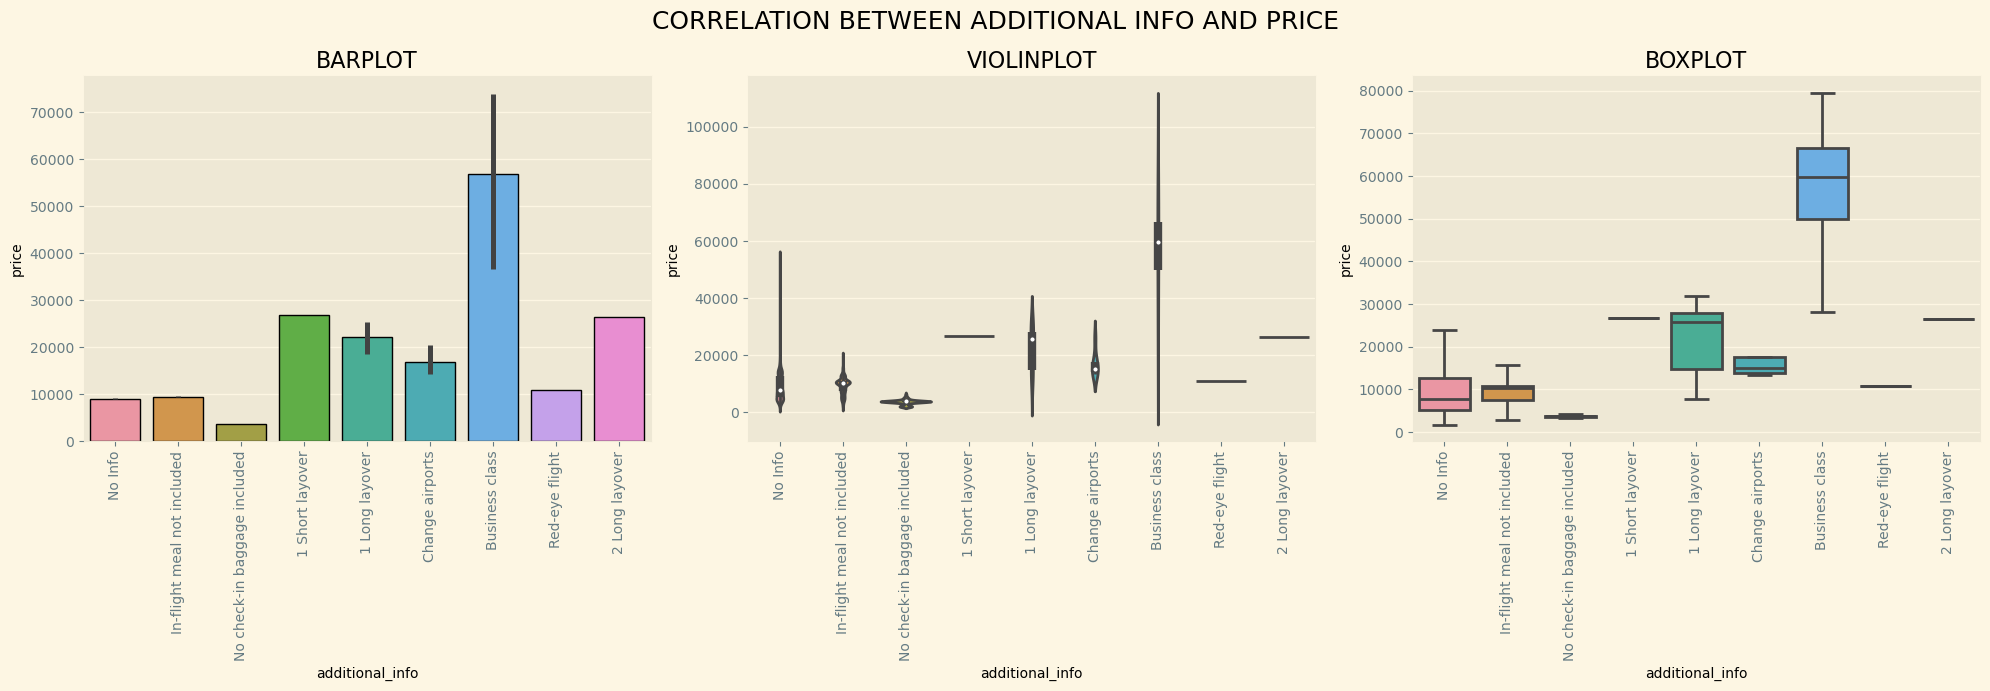

In [540]:
f, ax = plt.subplots(1, 3, figsize=(20, 7))
sns.barplot(data=df, x='additional_info', y='price', edgecolor='black',ax=ax[0])
ax[0].set_title('BARPLOT')
ax[0].set_xticklabels(df_arrival_time['additional_info'].unique(), rotation=90) 

sns.violinplot(data=df, x='additional_info', y='price', showfliers=True, ax=ax[1])
ax[1].set_title("VIOLINPLOT")
ax[1].set_xticklabels(df_arrival_time['additional_info'].unique(), rotation=90) 

sns.boxplot(data=df, x='additional_info', y='price', showfliers=False, ax=ax[2])
ax[2].set_title("BOXPLOT")
ax[2].set_xticklabels(df_arrival_time['additional_info'].unique(), rotation=90) 

plt.suptitle("CORRELATION BETWEEN ADDITIONAL INFO AND PRICE", fontsize = 18)
plt.tight_layout()
plt.show()